# 0 Connect drive or upload the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#5 install libraries and dependencies

In [ ]:
!pip install transformers nltk pandas numpy matplotlib seaborn wordcloud scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
#
import re
from collections import Counter

In [ ]:
# install data NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#10 dataset

In [ ]:
d_dt=pd.read_csv("/content/drive/MyDrive/Dataset_P1/dataset.csv")

#15 statistics, data comments

In [ ]:
# check info data
print(d_dt.shape)
print(d_dt.columns)

(20800, 5)
Index(['id', 'title', 'author', 'text', 'label'], dtype='object')


In [ ]:
txt_length = d_dt.text.str.split().str.len()
title_length = d_dt.title.str.split().str.len()
print("Text length statistics:")
print(txt_length.describe())
print("\nTitle length statistics:")
print(title_length.describe())

Text length statistics:
count    20761.000000
mean       760.308126
std        869.525988
min          0.000000
25%        269.000000
50%        556.000000
75%       1052.000000
max      24234.000000
Name: text, dtype: float64

Title length statistics:
count    20242.000000
mean        12.420709
std          4.098735
min          1.000000
25%         10.000000
50%         13.000000
75%         15.000000
max         72.000000
Name: title, dtype: float64


1: Unreliable
0: Reliable
Distribution of labels:
label
1    10413
0    10387
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
label
1    50.0
0    50.0
Name: proportion, dtype: float64


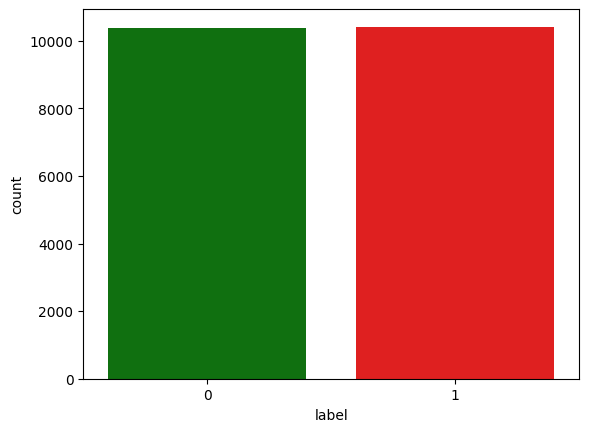

In [ ]:
# 1: Unreliable
# 0: Reliable
# create charts for labels
sns.countplot(x="label", hue="label", data=d_dt, palette=["green", "red"], legend=False);
print("1: Unreliable")
print("0: Reliable")
print("Distribution of labels:")
print(d_dt.label.value_counts());
print("----"*70)
print(round(d_dt.label.value_counts(normalize=True),2)*100);

#20 Dataset Preprocessing

In [ ]:
column_n = ['id', 'title', 'author', 'text', 'label']
remove_c = ['id','author']
target_col = ['label']
text_f = ['title', 'text']

ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

# Removed unused clumns
def remove_unused_c(df, column_n=remove_c):
    return df.drop(column_n, axis=1)

# Impute null values with None
def null_process(feature_df):
    for col in text_f:
        feature_df.loc[feature_df[col].isnull(), col] = "None"
    return feature_df

# Cleaning text from unused characters
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+',b'',text)
    text = re.sub('\w*\d\w*','',text)
    return text

# Clean dataset
def clean_dataset(df):
    df = remove_unused_c(df)
    df = null_process(df)
    return df

# Preprocessing with Stop words
def preprocess_text(text):
    text = clean_text(text)
    wordlist = text.split()
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return  text

In [ ]:
df = clean_dataset(d_dt)
df["text"] = df.text.apply(preprocess_text)
df["title"] = df.title.apply(preprocess_text)

df = df[df['text'].notna()]
df['title'] = df['title'].fillna("")
df = df[df['label'].notna()]
df['processed_text'] = df['title'] + " " + df['text']

In [ ]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           20800 non-null  object
 1   text            20800 non-null  object
 2   label           20800 non-null  int64 
 3   processed_text  20800 non-null  object
dtypes: int64(1), object(3)
memory usage: 650.1+ KB
None


create train 80% valid 10% test 10% => due to little data

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
train_df.to_csv('/content/drive/MyDrive/Dataset_P1/train.csv', index=False)
valid_df.to_csv('/content/drive/MyDrive/Dataset_P1/valid.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/Dataset_P1/test.csv', index=False)

In [ ]:
print(test_df.columns)

Index(['title', 'text', 'label', 'processed_text'], dtype='object')


#30 SVM

In [ ]:
train_d = pd.read_csv('/content/drive/MyDrive/Dataset_P1/train.csv')
valid_d = pd.read_csv('/content/drive/MyDrive/Dataset_P1/valid.csv')

In [ ]:
X_train = train_d['processed_text']
y_train = train_d['label']

X_valid = valid_d['processed_text']
y_valid = valid_d['label']

In [ ]:
# feature TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)

In [ ]:
# Check
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_valid_tfidf.shape)
print("First 5 rows of X_train_tfidf:\n", X_train_tfidf[:5].toarray())
print("Vocabulary (First 10 words):\n", list(tfidf_vectorizer.vocabulary_.keys())[:10])


Shape of X_train_tfidf: (16640, 144987)
Shape of X_test_tfidf: (2080, 144987)
First 5 rows of X_train_tfidf:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vocabulary (First 10 words):
 ['raccoon', 'central', 'park', 'draw', 'crowd', 'warning', 'stay', 'away', 'new', 'york']


In [ ]:
#training
svm_classifier = SVC(kernel='linear',probability=True)
svm_classifier.fit(X_train_tfidf, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
# Check X_valid_tfidf
y_pred = svm_classifier.predict(X_valid_tfidf)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1082
           1       0.97      0.95      0.96       998

    accuracy                           0.96      2080
   macro avg       0.96      0.96      0.96      2080
weighted avg       0.96      0.96      0.96      2080

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


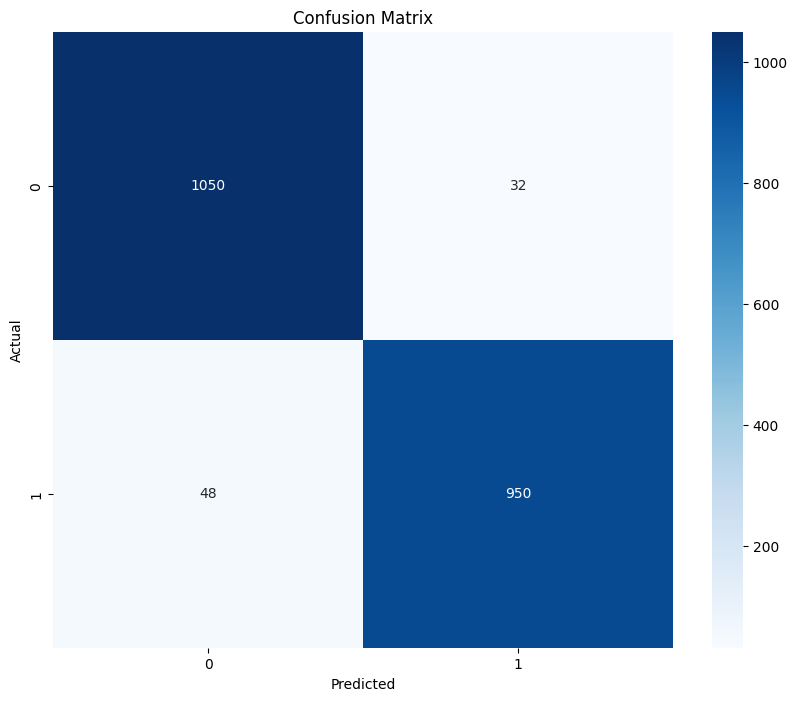

In [ ]:
# Check accuracy and matrix
print("Classification Report:")
print(classification_report(y_valid, y_pred))
print("----"*70)
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import joblib
joblib.dump(svm_classifier, '/content/drive/MyDrive/Dataset_P1/SVM_ver7.pkl')
joblib.dump(tfidf_vectorizer, '/content/drive/MyDrive/Dataset_P1/Tfidf_ver7.pkl')

['/content/drive/MyDrive/Dataset_P1/Tfidf_ver7.pkl']

In [ ]:
#load modul
import joblib
svm_classifier = joblib.load('/content/drive/MyDrive/Dataset_P1/SVM_ver7.pkl')
tfidf_vectorizer = joblib.load('/content/drive/MyDrive/Dataset_P1/Tfidf_ver7.pkl')


Evaluation on testset

In [ ]:
test_set=pd.read_csv('/content/drive/MyDrive/Dataset_P1/test.csv')

In [ ]:
y_test_d= test_set['label']
X_test_tfidf = tfidf_vectorizer.transform(test_set['processed_text'])
y_test_pred = svm_classifier.predict(X_test_tfidf)
print("Classification Report:")
print(classification_report(y_test_d, y_test_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1050
           1       0.97      0.97      0.97      1030

    accuracy                           0.97      2080
   macro avg       0.97      0.97      0.97      2080
weighted avg       0.97      0.97      0.97      2080



# 40 BERT

### 40.5 building a Classifier by Fine-tuning BERT

In [ ]:
!pip install transformers


In [ ]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.model_selection import train_test_split
import random

In [ ]:
model_name = "bert-base-uncased"
max_length = 512
#Load the tokenizer for the first time
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

In [ ]:
train_d = pd.read_csv('/content/drive/MyDrive/Dataset_P1/train.csv')
valid_d = pd.read_csv('/content/drive/MyDrive/Dataset_P1/valid.csv')

In [ ]:
train_texts = train_d['processed_text'].tolist()
train_labels = train_d['label'].tolist()

valid_texts = valid_d['processed_text'].tolist()
valid_labels = valid_d['label'].tolist()

In [ ]:
# Use the BERT tokenizer to tokenize the dataset
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

## 40.10 Converting the encodings into a PyTorch dataset

In [ ]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)
# Convert tokenized data into a torch Dataset
train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)

In [ ]:
# Load BERT model for the first time
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
# Calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
# Initialize the training parameters
training_args = TrainingArguments(
    output_dir='./results',               # output directory
    num_train_epochs=1,
    per_device_train_batch_size=10,       # batch size per device during training
    per_device_eval_batch_size=20,
    warmup_steps=100,
    logging_dir='./logs',
    load_best_model_at_end=True,
    logging_steps=200,
    save_steps=200,
    evaluation_strategy="steps",
    report_to="none"
)

In [ ]:
#instantiate the trainer
trainer = Trainer(
    model=model,                         # model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [ ]:
#training
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,0.421900,0.206869,0.942788
400,0.220300,0.153843,0.957692
600,0.138100,0.157566,0.962981
800,0.167900,0.110029,0.964904
1000,0.116900,0.096880,0.975962
1200,0.085000,0.099505,0.977404
1400,0.100300,0.086799,0.979327
1600,0.093700,0.085888,0.978846


TrainOutput(global_step=1664, training_loss=0.16407739399717405, metrics={'train_runtime': 2212.5581, 'train_samples_per_second': 7.521, 'train_steps_per_second': 0.752, 'total_flos': 4378167961190400.0, 'train_loss': 0.16407739399717405, 'epoch': 1.0})

In [ ]:
# evaluate the current model after training
trainer.evaluate()

{'eval_loss': 0.08588764816522598,
 'eval_accuracy': 0.9788461538461538,
 'eval_runtime': 62.3661,
 'eval_samples_per_second': 33.351,
 'eval_steps_per_second': 1.668,
 'epoch': 1.0}

In [ ]:
#save
model_path = "/content/drive/MyDrive/Dataset_P1/bert"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/Dataset_P1/bert/tokenizer_config.json',
 '/content/drive/MyDrive/Dataset_P1/bert/special_tokens_map.json',
 '/content/drive/MyDrive/Dataset_P1/bert/vocab.txt',
 '/content/drive/MyDrive/Dataset_P1/bert/added_tokens.json',
 '/content/drive/MyDrive/Dataset_P1/bert/tokenizer.json')

## 40.15 test.csv

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

model_path = "/content/drive/MyDrive/TTT/bert"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

In [ ]:
def get_prediction(text, convert_to_label=False):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)

    # executing argmax function to get the candidate label
    d = {
        0: "real",
        1: "fake"
    }
    if convert_to_label:
      return d[int(probs.argmax())]
    else:
      return int(probs.argmax())

In [ ]:
import torch

import pandas as pd
from sklearn.metrics import accuracy_score
new_df = pd.read_csv('/content/drive/MyDrive/TTT/test.csv')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Get the prediction for all the test set
new_df["predicted_label"] = new_df["processed_text"].apply(get_prediction)

# Calculate accuracy if the true labels are in a column named 'label'
accuracy = accuracy_score(new_df["label"], new_df["predicted_label"])

# The accuracy
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


## 40.20 input data text

In [ ]:
def get_prediction(text, convert_to_label=False):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)

    # executing argmax function to get the candidate label
    d = {
        0: "real",
        1: "fake"
    }
        # extract probabilities as percentages
    true_prob = probs[0][0].item() * 100
    fake_prob = probs[0][1].item() * 100
    if convert_to_label:
        print(f"Prediction: {d[int(probs.argmax())]} ({true_prob:.2f}% real, {fake_prob:.2f}% fake)")
        return d[int(probs.argmax())]
    else:
        print(f"Prediction: {int(probs.argmax())} ({true_prob:.2f}% real, {fake_prob:.2f}% fake)")
        return int(probs.argmax())

In [ ]:
test_news= "Get short URL 0 18 0 0 Officials responsible for overpaying re-enlistment bonuses to soldiers a decade ago and officials who ordered those bonuses repaid earlier this month need to be held responsible, US Senate Armed Services Committee Chairman John McCain said in a statement. WASHINGTON (Sputnik) — Members of the National Guard in the US state of California were paid excessive bonuses at the height of conflicts in Iraq and Afghanistan and were ordered to repay those bonuses earlier this month after an audit discovered the overpayments. That is why I will work together with the Department of Defense and my colleagues in the Senate to explore all options available to hold those responsible for this unacceptable situation accountable and to ensure this never happens again, McCain stated on Wednesday. McCain called a Defense Department decision to suspend collection of the payments a long overdue first step. However, he added that thousands of service members and their families, whose lives have been disrupted through no fault of their own, are still waiting for certainty that the problem will be fixed. The Defense Department said earlier on Wednesday that about 2,000 soldiers are affected and that it will set up a system to review each case before any efforts to collect money resume. ..."
get_prediction(test_news, convert_to_label=True)

Prediction: fake (0.24% real, 99.76% fake)


'fake'